In [15]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib import table
import numpy as np
import pandas as pd
from scipy import signal
import gcsfs
from scipy.signal import detrend
from scipy.stats import linregress
import scipy.signal as signal
import matplotlib as mpl
from statsmodels.api import tsa
import statsmodels.api as sm
import xarray as xr
import zarr
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

# Supplemental Figure 1 (S1)

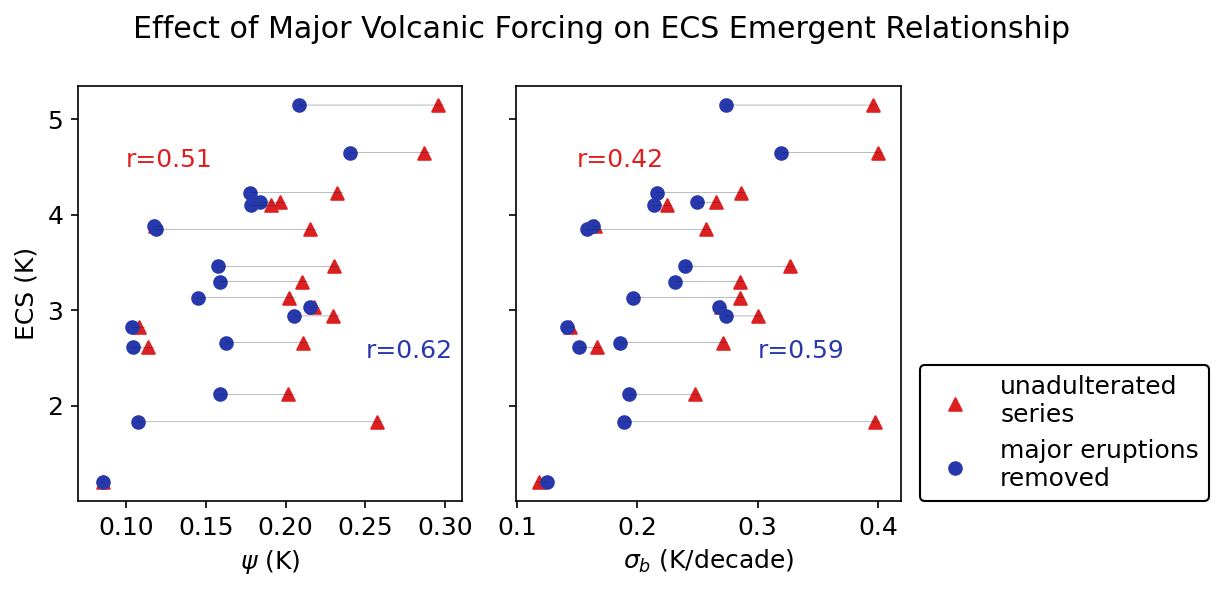

In [2]:
removed_color = '#2738ad'
volcano_color = '#de1f1f'

ec_data = pd.read_csv('data/ec_data.csv').drop('Unnamed: 0', axis=1)
fig, axs = plt.subplots(1, 2, figsize = (8.5, 4), sharey=True)
axs[0].scatter(ec_data['cox'], ec_data['ecs'], color = volcano_color, marker = '^')
slope, intercept, r, p, se = linregress(ec_data['cox'], ec_data['ecs'])
r_cox_original = r

axs[0].scatter(ec_data['rv_cox'], ec_data['ecs'], color = removed_color, marker = 'o')
slope, intercept, r, p, se = linregress(ec_data['rv_cox'], ec_data['ecs'])
r_cox_rv = r

for i in range(len(ec_data)):
    x_i = ec_data['rv_cox'][i]
    y_i = ec_data['ecs'][i]
    dx_i = x_i - ec_data['cox'][i]
    dy_i = 0
    axs[0].arrow(x_i, y_i, -1*dx_i, dy_i, linewidth = 0.05)

axs[0].text(0.1, 4.5, 'r='+str(np.round(r_cox_original,2)), color = volcano_color)
axs[0].text(0.25, 2.5, 'r='+str(np.round(r_cox_rv,2)), color = removed_color)

axs[1].scatter(ec_data['nijsse'], ec_data['ecs'], color = volcano_color, marker = '^', label = 'unadulterated\nseries')
slope, intercept, r, p, se = linregress(ec_data['nijsse'], ec_data['ecs'])
r_nijsse_original = r

axs[1].scatter(ec_data['rv_nijsse'], ec_data['ecs'], color = removed_color, marker = 'o', label = 'major eruptions\nremoved')
slope, intercept, r, p, se = linregress(ec_data['rv_nijsse'], ec_data['ecs'])
r_nijsse_rv = r

for i in range(len(ec_data)):
    x_i = ec_data['rv_nijsse'][i]
    y_i = ec_data['ecs'][i]
    dx_i = x_i - ec_data['nijsse'][i]
    dy_i = 0
    axs[1].arrow(x_i, y_i, -1*dx_i, dy_i, linewidth = 0.05)

axs[1].text(0.15, 4.5, 'r='+str(np.round(r_nijsse_original,2)), color = volcano_color)
axs[1].text(0.3, 2.5, 'r='+str(np.round(r_nijsse_rv,2)), color = removed_color)

fig.suptitle('Effect of Major Volcanic Forcing on ECS Emergent Relationship')

axs[1].legend(loc = (1.05, 0), edgecolor = 'black', framealpha = 1)

axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel(r'$\psi$ (K)')
axs[1].set_xlabel(r'$\sigma_{b}$ (K/decade)')

plt.tight_layout()
plt.savefig('figures/figure_s1.png', dpi=3000)

# Supplemental Figure 2 (S2)

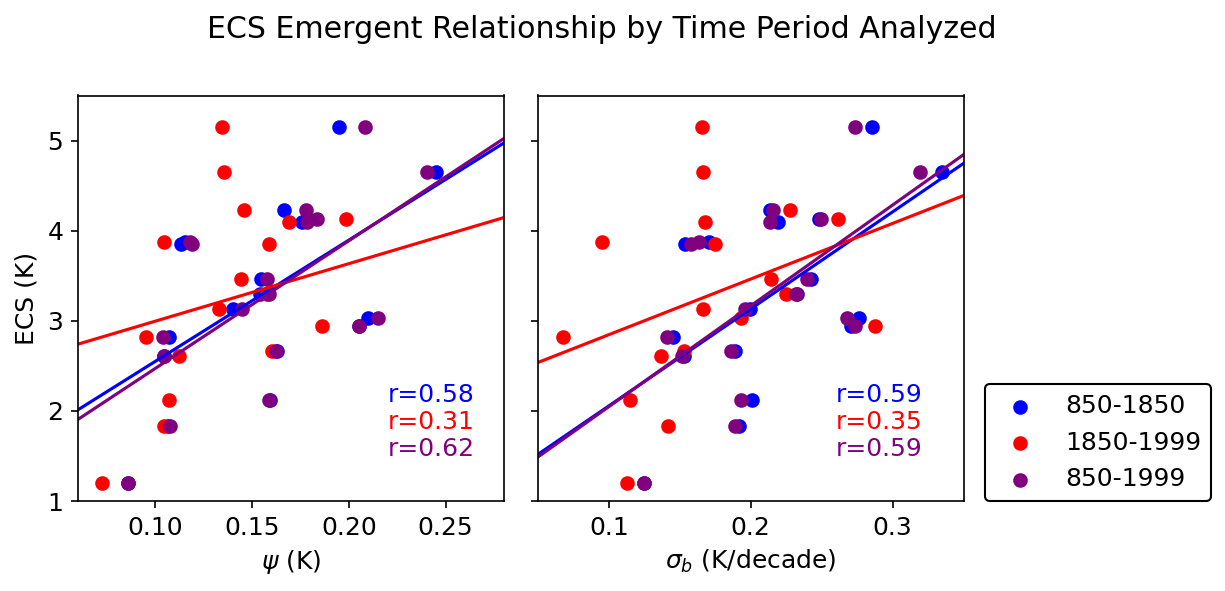

In [3]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import linregress
import matplotlib as mpl
from statsmodels.api import tsa
import statsmodels.api as sm
import xarray as xr

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

def get_forcing(saod):
    '''
    Takes in a timeseries of SAOD (numpy array) and outputs a forcing profile (in W/m^2)
    '''
    return np.multiply(-20.7, np.subtract(1, np.exp(np.multiply(-1, saod))))

def remove_volcano(timeseries, temp_anomaly):
    X = temp_anomaly # independent variable
    y = timeseries   # dependent variable

    # to get intercept -- this is optional
    X = sm.add_constant(X)

    # fit the regression model
    reg = sm.OLS(y, X).fit()
    
    return reg.resid.values

# take a spatial average
def weighted_mean(da):
    
    # make 2d array of weights in case that lat is 1d
    if len(da.lat.shape)==2:
        weights=np.cos(np.deg2rad(da.lat))
    elif len(da.lat.shape)==1:
        weights = xr.ones_like(da)* (np.cos(np.deg2rad((da.lat))).values)
        
    # turn weights into nan where da is nan
    weights = weights*da/da
    
    if 'lat' in da.dims:
        wm = (da*weights).sum(dim=['lat'], skipna=True) / weights.sum(dim=['lat'], skipna=True)

    elif 'i' in da.dims:
        wm = (da*weights).sum(dim=['i','j'], skipna=True) / weights.sum(dim=['i','j'], skipna=True)
    elif 'nlat' in da.dims:
        wm = (da*weights).sum(dim=['nlat','nlon'], skipna=True) / weights.sum(dim=['nlat','nlon'], skipna=True)
    elif 'x' in da.dims:
        wm = (da*weights).sum(dim=['x','y'], skipna=True) / weights.sum(dim=['x','y'], skipna=True)
    return wm

def compute_cox(x):
    x = x[~np.isnan(x)]
    psi_vals=[]
    for i in np.arange(0, len(x)-55):
        y = signal.detrend(x[i:i+55])
        auto_m1 = tsa.acf(y,nlags=1) # autocorrelation function from statsmodels
        auto_m1b = auto_m1[1]    # select 1 lag autocorrelation value
        sigma_m1= np.std(y)
        log_m1= np.log(auto_m1b)
        log_m1b = np.abs(log_m1)   # take absolute value
        sqrt_m1 = np.sqrt(log_m1b)
        psi = sigma_m1/sqrt_m1
        psi_vals.append(psi)
    return np.nanmean(psi_vals)

def compute_nijsse(x, length=10):
    # remove NaNs from the timeseries
    x = np.array(x)
    mask = ~np.isnan(x)
    x = x[mask]
    # fill it with slopes
    slopes = []
    i = 0
    while i < len(x)-length:
        slope, intercept, r, p, se = linregress(np.arange(0,length), x[i:i+length])
        slopes.append(length*slope)
        i+=length
    return np.nanstd(slopes)

evolv2k_ts = weighted_mean(xr.open_dataset('data/evolv2k.nc')).sel(time=slice(850,1850))
evolv2k_saod = []
i=850
while i <= 1850:
    evolv2k_saod.append(float(evolv2k_ts.sel(time=slice(i, i+1)).mean(dim='time').aod550.values))
    i+=1
evolv2k_forcing = get_forcing(evolv2k_saod)

gao_2008_saod = np.divide(pd.read_csv('data/gao_2008.csv')['gm'].values.astype(float), 1.2*10**3)
gao_2008_forcing = get_forcing(gao_2008_saod)
crowley_2000_forcing = pd.read_csv('data/crowley_2000.txt', delimiter = '\t')['Vol.hl.cct'].values

crowley_2008_saod = pd.read_csv('data/crowley_2008.txt', delimiter = '\t')['AOD'].values
crowley_2008_forcing = get_forcing(crowley_2008_saod)

df = pd.read_csv('data/ts.csv')
model_keys = df.keys()[2:]
forcings = ['gao', 'gao', 'crowley_08', 'crowley_00',
            'evolv2k', 'crowley_08', 'gao', 'evolv2k',
            'crowley_08', 'gao', 'evolv2k', 'gao', 
            'evolv2k', 'evolv2k', 'evolv2k', 'crowley_08',
            'evolv2k', 'evolv2k']
ecs_vals = []
original_cox = []
rv_cox = []
original_nijsse = []
rv_nijsse = []

t = pd.read_csv('data/ecs.csv')

for i in range(len(model_keys)):
    ts = df[model_keys[i]].values
    ts_past1000 = ts[:1001]
    if model_keys[i] == 'HadCM3':
        X = crowley_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts_past1000))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts_past1000))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
    elif forcings[i] == 'gao':
        X = gao_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts_past1000))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts_past1000))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
    elif forcings[i] == 'crowley_00':
        X = crowley_2000_forcing
        y = ts[151:]
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
    elif forcings[i] == 'crowley_08':
        X = crowley_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts_past1000))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts_past1000))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
    elif forcings[i] == 'evolv2k':
        X = evolv2k_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts_past1000))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts_past1000))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
        
sigma_1850 = rv_nijsse
sigma_full = ec_data['rv_nijsse']

cox_1850 = rv_cox
cox_full = ec_data['rv_cox']

ecs = ec_data['ecs']

df = pd.read_csv('data/ts.csv')
model_keys = df.keys()[2:]

sigma_historical = []
cox_historical = []

t = pd.read_csv('data/ec_data.csv')

for i in range(len(model_keys)):
    ecs_vals.append(t[t['model']==model_keys[i]]['ecs'].values[0])
    ts = df[model_keys[i]].values
    ts_historical = ts[1000:]
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'CMIP5':
        cox_historical.append(compute_cox(ts_historical))
        sigma_historical.append(compute_nijsse(ts_historical))
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'CMIP6':
        cox_historical.append(compute_cox(ts_historical))
        sigma_historical.append(compute_nijsse(ts_historical))
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'na':
        cox_historical.append(compute_cox(ts_historical))
        sigma_historical.append(compute_nijsse(ts_historical))
        
color_1850 = 'blue'
color_historical = 'red'
color_full = 'purple'


fig, axs = plt.subplots(1, 2, figsize = (8.5, 4), sharey=True)

axs[0].scatter(cox_1850, ecs, color = color_1850, marker = 'o', label = '850-1850')
slope, intercept, r, p, se = linregress(cox_1850, ecs)
r_1850_psi = r
x=np.linspace(0.05, 0.35, 100)
axs[0].plot(x,slope*x+intercept, color = color_1850)

axs[0].scatter(cox_historical, ecs, color = color_historical, marker = 'o', label = '1850-1999')
slope, intercept, r, p, se = linregress(cox_historical, ecs)
r_historical_psi = r
x=np.linspace(0.05, 0.35, 100)
axs[0].plot(x,slope*x+intercept, color = color_historical)

axs[0].scatter(cox_full, ecs, color = color_full, marker = 'o', label = '850-1999')
slope, intercept, r, p, se = linregress(cox_full, ecs)
r_full_psi = r
x=np.linspace(0.05, 0.35, 100)
axs[0].plot(x,slope*x+intercept, color = color_full)

axs[0].set_xlim(0.06,0.28)
axs[0].set_ylim(1,5.5)

axs[1].scatter(sigma_1850, ecs, color = color_1850, marker = 'o', label = '850-1850')
slope, intercept, r, p, se = linregress(sigma_1850, ecs)
r_1850_sigma = r
x=np.linspace(0.05, 0.35, 100)
axs[1].plot(x,slope*x+intercept, color = color_1850)

axs[1].scatter(sigma_historical, ecs, color = 'red', marker = 'o', label = '1850-1999')
slope, intercept, r, p, se = linregress(sigma_historical, ecs)
r_historical_sigma = r
x=np.linspace(0.05, 0.35, 100)
axs[1].plot(x,slope*x+intercept, color = color_historical)

axs[1].scatter(sigma_full, ecs, color = color_full, marker = 'o', label = '850-1999')
slope, intercept, r, p, se = linregress(sigma_full, ecs)
r_full_sigma = r
x=np.linspace(0.05, 0.35, 100)
axs[1].plot(x,slope*x+intercept, color = color_full)

axs[1].set_xlim(0.05, 0.35)
axs[1].set_ylim(1, 5.5)


axs[1].text(0.26, 1.5, 'r='+str(np.round(r_full_sigma,2)), color = color_full)
axs[1].text(0.26, 2.1, 'r='+str(np.round(r_1850_sigma,2)), color = color_1850)
axs[1].text(0.26, 1.8, 'r='+str(np.round(r_historical_sigma,2)), color = color_historical)

axs[0].text(0.22, 1.5, 'r='+str(np.round(r_full_psi,2)), color = color_full)
axs[0].text(0.22, 2.1, 'r='+str(np.round(r_1850_psi,2)), color = color_1850)
axs[0].text(0.22, 1.8, 'r='+str(np.round(r_historical_psi,2)), color = color_historical)

fig.suptitle('ECS Emergent Relationship by Time Period Analyzed')

axs[1].legend(loc = (1.05, 0), edgecolor = 'black', framealpha = 1)

axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel(r'$\psi$ (K)')
axs[1].set_xlabel(r'$\sigma_{b}$ (K/decade)')

plt.tight_layout()
plt.savefig('figures/figure_s2.png', dpi=3000)

# Supplemental Figure 3 (S3)

In [51]:
from matplotlib import pyplot as plt
from statsmodels.api import tsa
from scipy import signal
from scipy.stats import linregress
from scipy import stats
import numpy as np
import pandas as pd
import warnings
import xarray as xr
import random
from scipy.stats import chi2

warnings.filterwarnings('ignore')

"""Operations on cartesian geographical grid."""
import numpy as np

EARTH_RADIUS = 6371000.0  # m


def _guess_bounds(points, bound_position=0.5):
    """
    Guess bounds of grid cells.
    
    Simplified function from iris.coord.Coord.
    
    Parameters
    ----------
    points: numpy.array
        Array of grid points of shape (N,).
    bound_position: float, optional
        Bounds offset relative to the grid cell centre.
    Returns
    -------
    Array of shape (N, 2).
    """
    diffs = np.diff(points)
    diffs = np.insert(diffs, 0, diffs[0])
    diffs = np.append(diffs, diffs[-1])

    min_bounds = points - diffs[:-1] * bound_position
    max_bounds = points + diffs[1:] * (1 - bound_position)

    return np.array([min_bounds, max_bounds]).transpose()


def _quadrant_area(radian_lat_bounds, radian_lon_bounds, radius_of_earth):
    """
    Calculate spherical segment areas.
    Taken from SciTools iris library.
    Area weights are calculated for each lat/lon cell as:
        .. math::
            r^2 (lon_1 - lon_0) ( sin(lat_1) - sin(lat_0))
    The resulting array will have a shape of
    *(radian_lat_bounds.shape[0], radian_lon_bounds.shape[0])*
    The calculations are done at 64 bit precision and the returned array
    will be of type numpy.float64.
    Parameters
    ----------
    radian_lat_bounds: numpy.array
        Array of latitude bounds (radians) of shape (M, 2)
    radian_lon_bounds: numpy.array
        Array of longitude bounds (radians) of shape (N, 2)
    radius_of_earth: float
        Radius of the Earth (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas of shape (M, N).
    """
    # ensure pairs of bounds
    if (
        radian_lat_bounds.shape[-1] != 2
        or radian_lon_bounds.shape[-1] != 2
        or radian_lat_bounds.ndim != 2
        or radian_lon_bounds.ndim != 2
    ):
        raise ValueError("Bounds must be [n,2] array")

    # fill in a new array of areas
    radius_sqr = radius_of_earth ** 2
    radian_lat_64 = radian_lat_bounds.astype(np.float64)
    radian_lon_64 = radian_lon_bounds.astype(np.float64)

    ylen = np.sin(radian_lat_64[:, 1]) - np.sin(radian_lat_64[:, 0])
    xlen = radian_lon_64[:, 1] - radian_lon_64[:, 0]
    areas = radius_sqr * np.outer(ylen, xlen)

    # we use abs because backwards bounds (min > max) give negative areas.
    return np.abs(areas)


def grid_cell_areas(lon1d, lat1d, radius=EARTH_RADIUS):
    """
    Calculate grid cell areas given 1D arrays of longitudes and latitudes
    for a planet with the given radius.
    
    Parameters
    ----------
    lon1d: numpy.array
        Array of longitude points [degrees] of shape (M,)
    lat1d: numpy.array
        Array of latitude points [degrees] of shape (M,)
    radius: float, optional
        Radius of the planet [metres] (currently assumed spherical)
    Returns
    -------
    Array of grid cell areas [metres**2] of shape (M, N).
    """
    lon_bounds_radian = np.deg2rad(_guess_bounds(lon1d))
    lat_bounds_radian = np.deg2rad(_guess_bounds(lat1d))
    area = _quadrant_area(lat_bounds_radian, lon_bounds_radian, radius)
    return area


def calc_spatial_mean(
    xr_da, lon_name="longitude", lat_name="latitude", radius=EARTH_RADIUS
):
    """
    Calculate spatial mean of xarray.DataArray with grid cell weighting.
    
    Parameters
    ----------
    xr_da: xarray.DataArray
        Data to average
    lon_name: str, optional
        Name of x-coordinate
    lat_name: str, optional
        Name of y-coordinate
    radius: float
        Radius of the planet [metres], currently assumed spherical (not important anyway)
    Returns
    -------
    Spatially averaged xarray.DataArray.
    """
    lon = xr_da[lon_name].values
    lat = xr_da[lat_name].values

    area_weights = grid_cell_areas(lon, lat, radius=radius)
    aw_factor = area_weights / area_weights.max()

    return (xr_da * aw_factor).mean(dim=[lon_name, lat_name])


def calc_spatial_integral(
    xr_da, lon_name="longitude", lat_name="latitude", radius=EARTH_RADIUS
):
    """
    Calculate spatial integral of xarray.DataArray with grid cell weighting.
    
    Parameters
    ----------
    xr_da: xarray.DataArray
        Data to average
    lon_name: str, optional
        Name of x-coordinate
    lat_name: str, optional
        Name of y-coordinate
    radius: float
        Radius of the planet [metres], currently assumed spherical (not important anyway)
    Returns
    -------
    Spatially averaged xarray.DataArray.
    """
    lon = xr_da[lon_name].values
    lat = xr_da[lat_name].values

    area_weights = grid_cell_areas(lon, lat, radius=radius)

    return (xr_da * area_weights).sum(dim=[lon_name, lat_name])

# computes the Cox metric for a given window
def cox_metric(x):
    auto_m1 = tsa.acf(x,nlags=1) # autocorrelation function from statsmodels
    auto_m1b = np.abs(auto_m1[1])    # select 1 lag autocorrelation value
    sigma_m1= np.std(x, ddof=1) # take the sample standard deviation (fixed from previous code)
    log_m1= np.log(auto_m1b)   # compute the base-e logarithm
    log_m1b = np.abs(log_m1)   # take absolute value
    sqrt_m1 = np.sqrt(log_m1b) # take square root
    theta = sigma_m1/sqrt_m1 # compute theta
    return theta # return theta

# computes the average Cox metric across all windows, given a whole time series
def calc_cox(x):
    # x=x[1000:] # takes the most recent 1000 years
    cox_vals=np.zeros(len(x)-55) # builds array to store the cox estimates
    i=0 # window counter
    j=0 # storage counter
    while i<len(x)-55: # while loop cycles through timeseries to build windows/cox estimates
        cox_vals[j]=(cox_metric(signal.detrend(x[i:i+55])))  # detrend, compute and store the Cox estimate
        i+=1 # increment window counter
        j+=1 # increment storage counter
    # return np.mean(cox_vals) # return the mean Cox estimate across the timeseries
    return cox_vals

def calc_nijsse(x, length=10):
    x = np.array(x)
    mask = ~np.isnan(x)
    x = x[mask]
    slopes = []
    i = 0
    while i < len(x) - length:
        slope, intercept, r, p, se = linregress(np.arange(0, length), x[i:i+length])
        slopes.append(length*slope)
        i+=length
    return slopes

cox_new_1850_2000 = []
nijsse_new_1850_2000 = []

PAGES=pd.read_csv('data/pages_2k/CPS.txt',sep='\t',header=(0))
ds_cps=PAGES[(PAGES['Year_CE']>=1850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_cps = []
nijsse_vals_cps = []
for key in ds_cps.keys():
    cox_vals_cps.append(calc_cox(ds_cps[key]))
    nijsse_vals_cps.append(calc_nijsse(ds_cps[key]))
print('cps')
PAGES=pd.read_csv('data/pages_2k/PCR.txt',sep='\t',header=(0))
ds_pcr=PAGES[(PAGES['Year_CE']>=1850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_pcr = []
nijsse_vals_pcr = []
for key in ds_pcr.keys():
    cox_vals_pcr.append(calc_cox(ds_pcr[key]))
    nijsse_vals_pcr.append(calc_nijsse(ds_pcr[key]))
print('pcr')
PAGES=pd.read_csv('data/pages_2k/M08.txt',sep='\t',header=(0))
ds_m08=PAGES[(PAGES['Year_CE']>=1850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_m08 = []
nijsse_vals_m08 = []
for key in ds_m08.keys():
    cox_vals_m08.append(calc_cox(ds_m08[key]))
    nijsse_vals_m08.append(calc_nijsse(ds_m08[key]))
print('m08')
PAGES=pd.read_csv('data/pages_2k/OIE.txt',sep='\t',header=(0))
ds_oie=PAGES[(PAGES['Year_CE']>=1850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_oie = []
nijsse_vals_oie = []
for key in ds_oie.keys():
    cox_vals_oie.append(calc_cox(ds_oie[key]))
    nijsse_vals_oie.append(calc_nijsse(ds_oie[key]))
print('oie')
PAGES=pd.read_csv('data/pages_2k/BHM.txt',sep='\t',header=(0))
ds_bhm=PAGES[(PAGES['Year_CE']>=1850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_bhm = []
nijsse_vals_bhm = []
for key in ds_bhm.keys():
    cox_vals_bhm.append(calc_cox(ds_bhm[key]))
    nijsse_vals_bhm.append(calc_nijsse(ds_bhm[key]))
print('bhm')
PAGES=pd.read_csv('data/pages_2k/PAI.txt',sep='\t',header=(0))
ds_pai=PAGES[(PAGES['Year_CE']>=1850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_pai = []
nijsse_vals_pai = []
for key in ds_pai.keys():
    cox_vals_pai.append(calc_cox(ds_pai[key]))
    nijsse_vals_pai.append(calc_nijsse(ds_pai[key]))
print('pai')
PAGES=pd.read_csv('data/pages_2k/DA.txt',sep='\t',header=(0))
ds_da=PAGES[(PAGES['Year_CE']>=1850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_da = []
nijsse_vals_da = []
for key in ds_da.keys():
    cox_vals_da.append(calc_cox(ds_da[key]))
    nijsse_vals_da.append(calc_nijsse(ds_da[key]))
print('da')

cox_vals_new_1850_2000 = [
    cox_vals_cps,
    cox_vals_pcr,
    cox_vals_m08,
    cox_vals_oie,
    cox_vals_bhm,
    cox_vals_pai,
    cox_vals_da,
]

nijsse_vals_new_1850_2000 = [
    nijsse_vals_cps,
    nijsse_vals_pcr,
    nijsse_vals_m08,
    nijsse_vals_oie,
    nijsse_vals_bhm,
    nijsse_vals_pai,
    nijsse_vals_da,
]

cox_estimates_pages2k = np.zeros((7, 3))
for i in range(len(cox_vals_new_1850_2000)):
    lower_bounds = []
    central_estimates = []
    upper_bounds = []
    for j in range(len(cox_vals_new_1850_2000[0])):
        u=np.mean(cox_vals_new_1850_2000[i][j])
        s=np.std(cox_vals_new_1850_2000[i][j], ddof=1)
        central_estimates.append(u)
        lower_bounds.append(u-0.95*s)
        upper_bounds.append(u+0.95*s)
    cox_estimates_pages2k[i][0] = np.mean(lower_bounds)
    cox_estimates_pages2k[i][1] = np.mean(central_estimates)
    cox_estimates_pages2k[i][2] = np.mean(upper_bounds)

nijsse_estimates_pages2k = np.zeros((7, 3))
for i in range(len(nijsse_vals_new_1850_2000)):
    lower_bounds = []
    central_estimates = []
    upper_bounds = []
    for j in range(len(nijsse_vals_new_1850_2000[0])):
        s = np.std(nijsse_vals_new_1850_2000[i][j], ddof=1)
        n = len(nijsse_vals_new_1850_2000[i][j])
        central_estimates.append(s)
        lower_bounds.append(np.sqrt((n-1)*s**2/chi2.ppf(1-(0.34/2), n)))
        upper_bounds.append(np.sqrt((n-1)*s**2/chi2.ppf(0.34/2, n)))
    nijsse_estimates_pages2k[i][0] = np.mean(lower_bounds)
    nijsse_estimates_pages2k[i][1] = np.mean(central_estimates)
    nijsse_estimates_pages2k[i][2] = np.mean(upper_bounds)

cox_estimate_hadcrut4 = np.zeros(3)
for i in range(1,101):
    ts = calc_cox(calc_spatial_mean(xr.open_dataset('data/HadCRUT4/HadCRUT.4.6.0.0.anomalies.'+str(i)+'.nc').groupby('time.year').mean('time').sel(year=slice(1850,2000)).temperature_anomaly))
    u = np.mean(ts)
    s = np.std(ts, ddof=1)
    cox_estimate_hadcrut4[0] = u-0.95*s
    cox_estimate_hadcrut4[1] = u
    cox_estimate_hadcrut4[2] = u+0.95*s

nijsse_estimate_hadcrut4 = np.zeros(3)
for i in range(1,101):
    ts = calc_nijsse(calc_spatial_mean(xr.open_dataset('data/HadCRUT4/HadCRUT.4.6.0.0.anomalies.'+str(i)+'.nc').groupby('time.year').mean('time').sel(year=slice(1850,2000)).temperature_anomaly))
    s = np.std(ts, ddof=1)
    n = len(ts)
    nijsse_estimate_hadcrut4[0] = np.sqrt((n-1)*s**2/chi2.ppf(1-(0.34/2), n))
    nijsse_estimate_hadcrut4[1] = s
    nijsse_estimate_hadcrut4[2] = np.sqrt((n-1)*s**2/chi2.ppf(0.34/2, n))

cox_new_850_2000 = []
nijsse_new_850_2000 = []

PAGES=pd.read_csv('data/pages_2k/CPS.txt',sep='\t',header=(0))
ds_cps=PAGES[(PAGES['Year_CE']>=850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_cps = []
nijsse_vals_cps = []
for key in ds_cps.keys():
    cox_vals_cps.append(calc_cox(ds_cps[key]))
    nijsse_vals_cps.append(calc_nijsse(ds_cps[key]))
print('cps')
PAGES=pd.read_csv('data/pages_2k/PCR.txt',sep='\t',header=(0))
ds_pcr=PAGES[(PAGES['Year_CE']>=850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_pcr = []
nijsse_vals_pcr = []
for key in ds_pcr.keys():
    cox_vals_pcr.append(calc_cox(ds_pcr[key]))
    nijsse_vals_pcr.append(calc_nijsse(ds_pcr[key]))
print('pcr')
PAGES=pd.read_csv('data/pages_2k/M08.txt',sep='\t',header=(0))
ds_m08=PAGES[(PAGES['Year_CE']>=850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_m08 = []
nijsse_vals_m08 = []
for key in ds_m08.keys():
    cox_vals_m08.append(calc_cox(ds_m08[key]))
    nijsse_vals_m08.append(calc_nijsse(ds_m08[key]))
print('m08')
PAGES=pd.read_csv('data/pages_2k/OIE.txt',sep='\t',header=(0))
ds_oie=PAGES[(PAGES['Year_CE']>=850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_oie = []
nijsse_vals_oie = []
for key in ds_oie.keys():
    cox_vals_oie.append(calc_cox(ds_oie[key]))
    nijsse_vals_oie.append(calc_nijsse(ds_oie[key]))
print('oie')
PAGES=pd.read_csv('data/pages_2k/BHM.txt',sep='\t',header=(0))
ds_bhm=PAGES[(PAGES['Year_CE']>=850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_bhm = []
nijsse_vals_bhm = []
for key in ds_bhm.keys():
    cox_vals_bhm.append(calc_cox(ds_bhm[key]))
    nijsse_vals_bhm.append(calc_nijsse(ds_bhm[key]))
print('bhm')
PAGES=pd.read_csv('data/pages_2k/PAI.txt',sep='\t',header=(0))
ds_pai=PAGES[(PAGES['Year_CE']>=850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_pai = []
nijsse_vals_pai = []
for key in ds_pai.keys():
    cox_vals_pai.append(calc_cox(ds_pai[key]))
    nijsse_vals_pai.append(calc_nijsse(ds_pai[key]))
print('pai')
PAGES=pd.read_csv('data/pages_2k/DA.txt',sep='\t',header=(0))
ds_da=PAGES[(PAGES['Year_CE']>=850) & (PAGES['Year_CE']<2000)].drop('Year_CE', axis=1)
cox_vals_da = []
nijsse_vals_da = []
for key in ds_da.keys():
    cox_vals_da.append(calc_cox(ds_da[key]))
    nijsse_vals_da.append(calc_nijsse(ds_da[key]))
print('da')

cox_vals_new_850_2000 = [
    cox_vals_cps,
    cox_vals_pcr,
    cox_vals_m08,
    cox_vals_oie,
    cox_vals_bhm,
    cox_vals_pai,
    cox_vals_da,
]

nijsse_vals_new_850_2000 = [
    nijsse_vals_cps,
    nijsse_vals_pcr,
    nijsse_vals_m08,
    nijsse_vals_oie,
    nijsse_vals_bhm,
    nijsse_vals_pai,
    nijsse_vals_da,
]

cox_estimates_pages2k_850_2000 = np.zeros((7, 3))
for i in range(len(cox_vals_new_850_2000)):
    lower_bounds = []
    central_estimates = []
    upper_bounds = []
    for j in range(len(cox_vals_new_850_2000[0])):
        u=np.mean(cox_vals_new_850_2000[i][j])
        s=np.std(cox_vals_new_850_2000[i][j], ddof=1)
        central_estimates.append(u)
        lower_bounds.append(u-0.95*s)
        upper_bounds.append(u+0.95*s)
    cox_estimates_pages2k_850_2000[i][0] = np.mean(lower_bounds)
    cox_estimates_pages2k_850_2000[i][1] = np.mean(central_estimates)
    cox_estimates_pages2k_850_2000[i][2] = np.mean(upper_bounds)

nijsse_estimates_pages2k_850_2000 = np.zeros((7, 3))
for i in range(len(nijsse_vals_new_850_2000)):
    lower_bounds = []
    central_estimates = []
    upper_bounds = []
    for j in range(len(nijsse_vals_new_850_2000[0])):
        s = np.std(nijsse_vals_new_850_2000[i][j], ddof=1)
        n = len(nijsse_vals_new_850_2000[i][j])
        central_estimates.append(s)
        lower_bounds.append(np.sqrt((n-1)*s**2/chi2.ppf(1-(0.34/2), n)))
        upper_bounds.append(np.sqrt((n-1)*s**2/chi2.ppf(0.34/2, n)))
    nijsse_estimates_pages2k_850_2000[i][0] = np.mean(lower_bounds)
    nijsse_estimates_pages2k_850_2000[i][1] = np.mean(central_estimates)
    nijsse_estimates_pages2k_850_2000[i][2] = np.mean(upper_bounds)

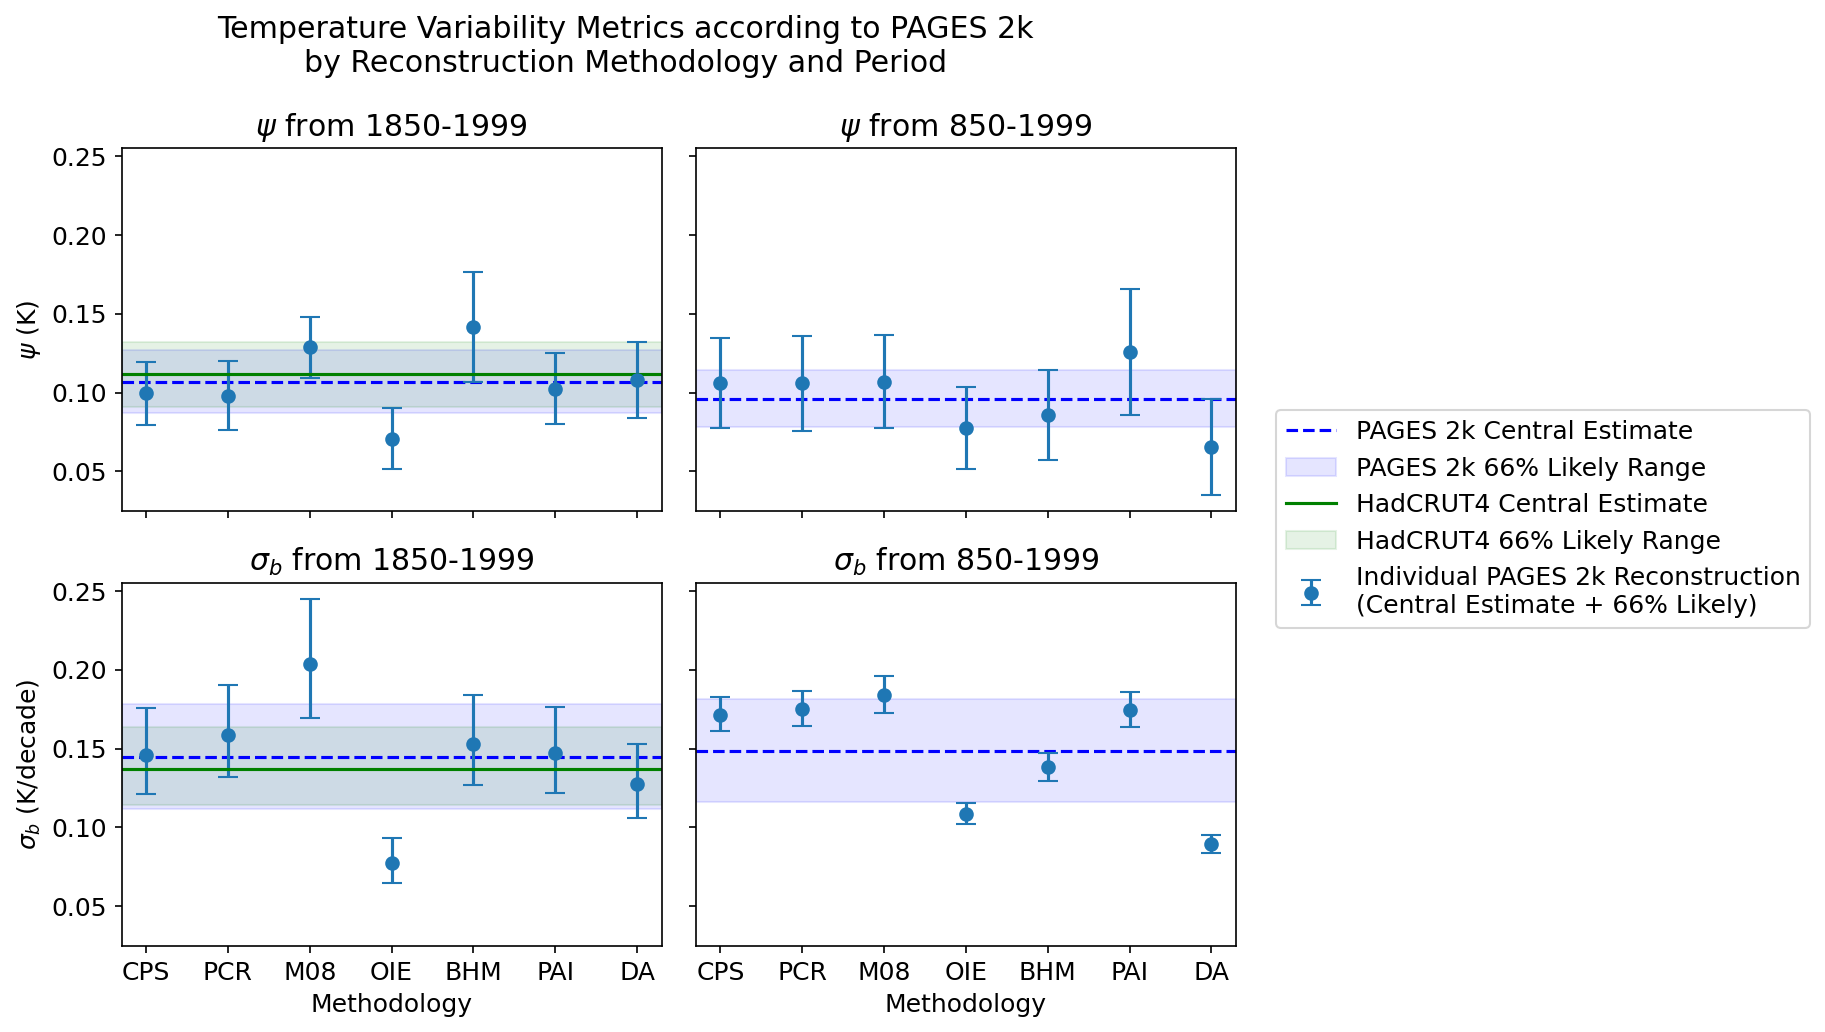

In [89]:
fig, axs = plt.subplots(2, 2, figsize = (8.5, 7), sharey=True, sharex=True)
methods = ['CPS', 'PCR', 'M08', 'OIE', 'BHM', 'PAI', 'DA']
x = methods
axs[0][0].set_title(r'$\psi$'+' from 1850-1999')
axs[0][0].axhline(y=np.mean(cox_estimates_pages2k.T[1]), color='blue', linestyle = '--')
axs[0][0].axhspan(np.mean(cox_estimates_pages2k.T[1])-0.95*np.std(cox_estimates_pages2k.T[1]),
                  np.mean(cox_estimates_pages2k.T[1])+0.95*np.std(cox_estimates_pages2k.T[1]),
                  color = 'blue', alpha = 0.1)
axs[0][0].errorbar(x, cox_estimates_pages2k.T[1],
                   yerr=[np.abs(np.subtract(cox_estimates_pages2k.T[1],cox_estimates_pages2k.T[0])), np.abs(np.subtract(cox_estimates_pages2k.T[2],cox_estimates_pages2k.T[1]))],
                   fmt='o', capsize=5)
axs[0][0].axhline(y=cox_estimate_hadcrut4[1], color='green')
axs[0][0].axhspan(cox_estimate_hadcrut4[0], cox_estimate_hadcrut4[2], color = 'green', alpha = 0.1)

axs[0][1].set_title(r'$\psi$'+' from 850-1999')
axs[0][1].axhline(y=np.mean(cox_estimates_pages2k_850_2000.T[1]), color='blue', linestyle = '--')
axs[0][1].axhspan(np.mean(cox_estimates_pages2k_850_2000.T[1])-0.95*np.std(cox_estimates_pages2k_850_2000.T[1]),
                  np.mean(cox_estimates_pages2k_850_2000.T[1])+0.95*np.std(cox_estimates_pages2k_850_2000.T[1]),
                  color = 'blue', alpha = 0.1)
axs[0][1].errorbar(x, cox_estimates_pages2k_850_2000.T[1],
                   yerr=[np.abs(np.subtract(cox_estimates_pages2k_850_2000.T[1],cox_estimates_pages2k_850_2000.T[0])), np.abs(np.subtract(cox_estimates_pages2k_850_2000.T[2],cox_estimates_pages2k_850_2000.T[1]))],
                   fmt='o', capsize=5)

axs[1][0].set_title(r'$\sigma_{b}$'+' from 1850-1999')
axs[1][0].axhline(y=np.mean(nijsse_estimates_pages2k.T[1]), color='blue', linestyle = '--', label = 'PAGES 2k Central Estimate')
axs[1][0].axhspan(np.mean(nijsse_estimates_pages2k.T[1])-0.95*np.std(nijsse_estimates_pages2k.T[1]),
                  np.mean(nijsse_estimates_pages2k.T[1])+0.95*np.std(nijsse_estimates_pages2k.T[1]),
                  color = 'blue', alpha = 0.1, label = 'PAGES 2k 66% Likely Range')
axs[1][0].errorbar(x, nijsse_estimates_pages2k.T[1],
                   yerr=[np.abs(np.subtract(nijsse_estimates_pages2k.T[1],nijsse_estimates_pages2k.T[0])), np.abs(np.subtract(nijsse_estimates_pages2k.T[2],nijsse_estimates_pages2k.T[1]))],
                   fmt='o', capsize=5)
axs[1][0].axhline(y=nijsse_estimate_hadcrut4[1], color='green', label = 'HadCRUT4 Central Estimate')
axs[1][0].axhspan(nijsse_estimate_hadcrut4[0], nijsse_estimate_hadcrut4[2], color = 'green', alpha = 0.1, label = 'HadCRUT4 66% Likely Range')

axs[1][1].set_title(r'$\sigma_{b}$'+' from 850-1999')
axs[1][1].axhline(y=np.mean(nijsse_estimates_pages2k_850_2000.T[1]), color='blue', linestyle = '--')
axs[1][1].axhspan(np.mean(nijsse_estimates_pages2k_850_2000.T[1])-0.95*np.std(nijsse_estimates_pages2k_850_2000.T[1]),
                  np.mean(nijsse_estimates_pages2k_850_2000.T[1])+0.95*np.std(nijsse_estimates_pages2k_850_2000.T[1]),
                  color = 'blue', alpha = 0.1)
axs[1][1].errorbar(x, nijsse_estimates_pages2k_850_2000.T[1],
                   yerr=[np.abs(np.subtract(nijsse_estimates_pages2k_850_2000.T[1],nijsse_estimates_pages2k_850_2000.T[0])), np.abs(np.subtract(nijsse_estimates_pages2k_850_2000.T[2],nijsse_estimates_pages2k_850_2000.T[1]))],
                   fmt='o', capsize=5, label='Individual PAGES 2k Reconstruction\n(Central Estimate + 66% Likely)')

axs[0][0].set_ylabel(r'$\psi$ (K)')
axs[1][0].set_ylabel(r'$\sigma_{b}$ (K/decade)')

axs[1][0].set_xlabel('Methodology')
axs[1][1].set_xlabel('Methodology')

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('Temperature Variability Metrics according to PAGES 2k\nby Reconstruction Methodology and Period')

plt.tight_layout()
plt.savefig('figures/figure_s3.png', dpi=1000, bbox_inches='tight')

# Supplemental Figure 4 (S4)

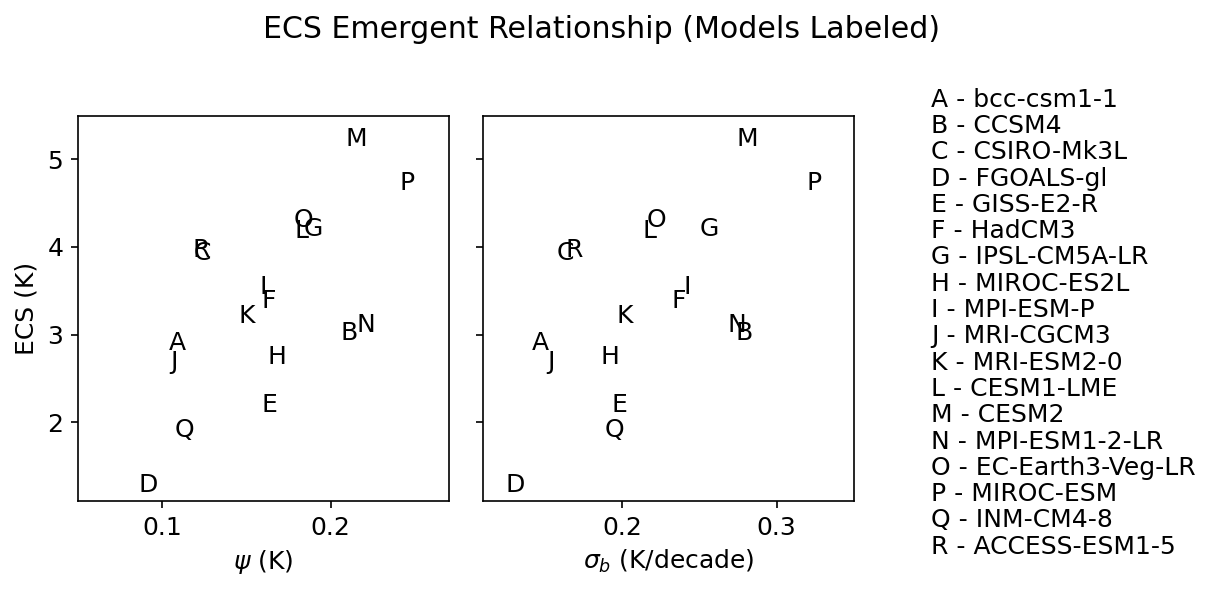

In [10]:
ec_data = pd.read_csv('data/ec_data.csv').drop('Unnamed: 0', axis=1)

# read in the timeseries dataframe
timeseries_df = pd.read_csv('data/ts.csv').drop('Unnamed: 0', axis=1)

# the columns of the dataframe are the model names
model_names = timeseries_df.columns[1:]

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8.5, 4))

fig.suptitle('ECS Emergent Relationship (Models Labeled)')
axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel(r'$\psi$ (K)')
axs[1].set_xlabel(r'$\sigma_{b}$ (K/decade)')
axs[0].set_xlim((0.05,0.27))
axs[0].set_ylim((1.1,5.5))
axs[1].set_ylim((1.1,5.5))
axs[1].set_xlim((0.11,0.35))

alphabet = ['A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H',
            'I', 'J', 'K', 'L',
            'M', 'N', 'O', 'P',
            'Q', 'R']

j = 5.6
for i in range(len(ec_data)):
    axs[0].text(ec_data['rv_cox'][i],
               ec_data['ecs'][i],
               alphabet[i])
    
    axs[1].text(ec_data['rv_nijsse'][i],
           ec_data['ecs'][i],
           alphabet[i])
    
    axs[1].text(0.4, j, alphabet[i] + ' - '+model_names[i])
    j -= 0.3

plt.tight_layout()
plt.savefig('figures/figure_s4.png', dpi=3000)

# Supplemental Figure 5 (S5)

available in the notebook, 'pp2k-ppe-pda.ipynb'

# Supplemental Figure 6 (S6)

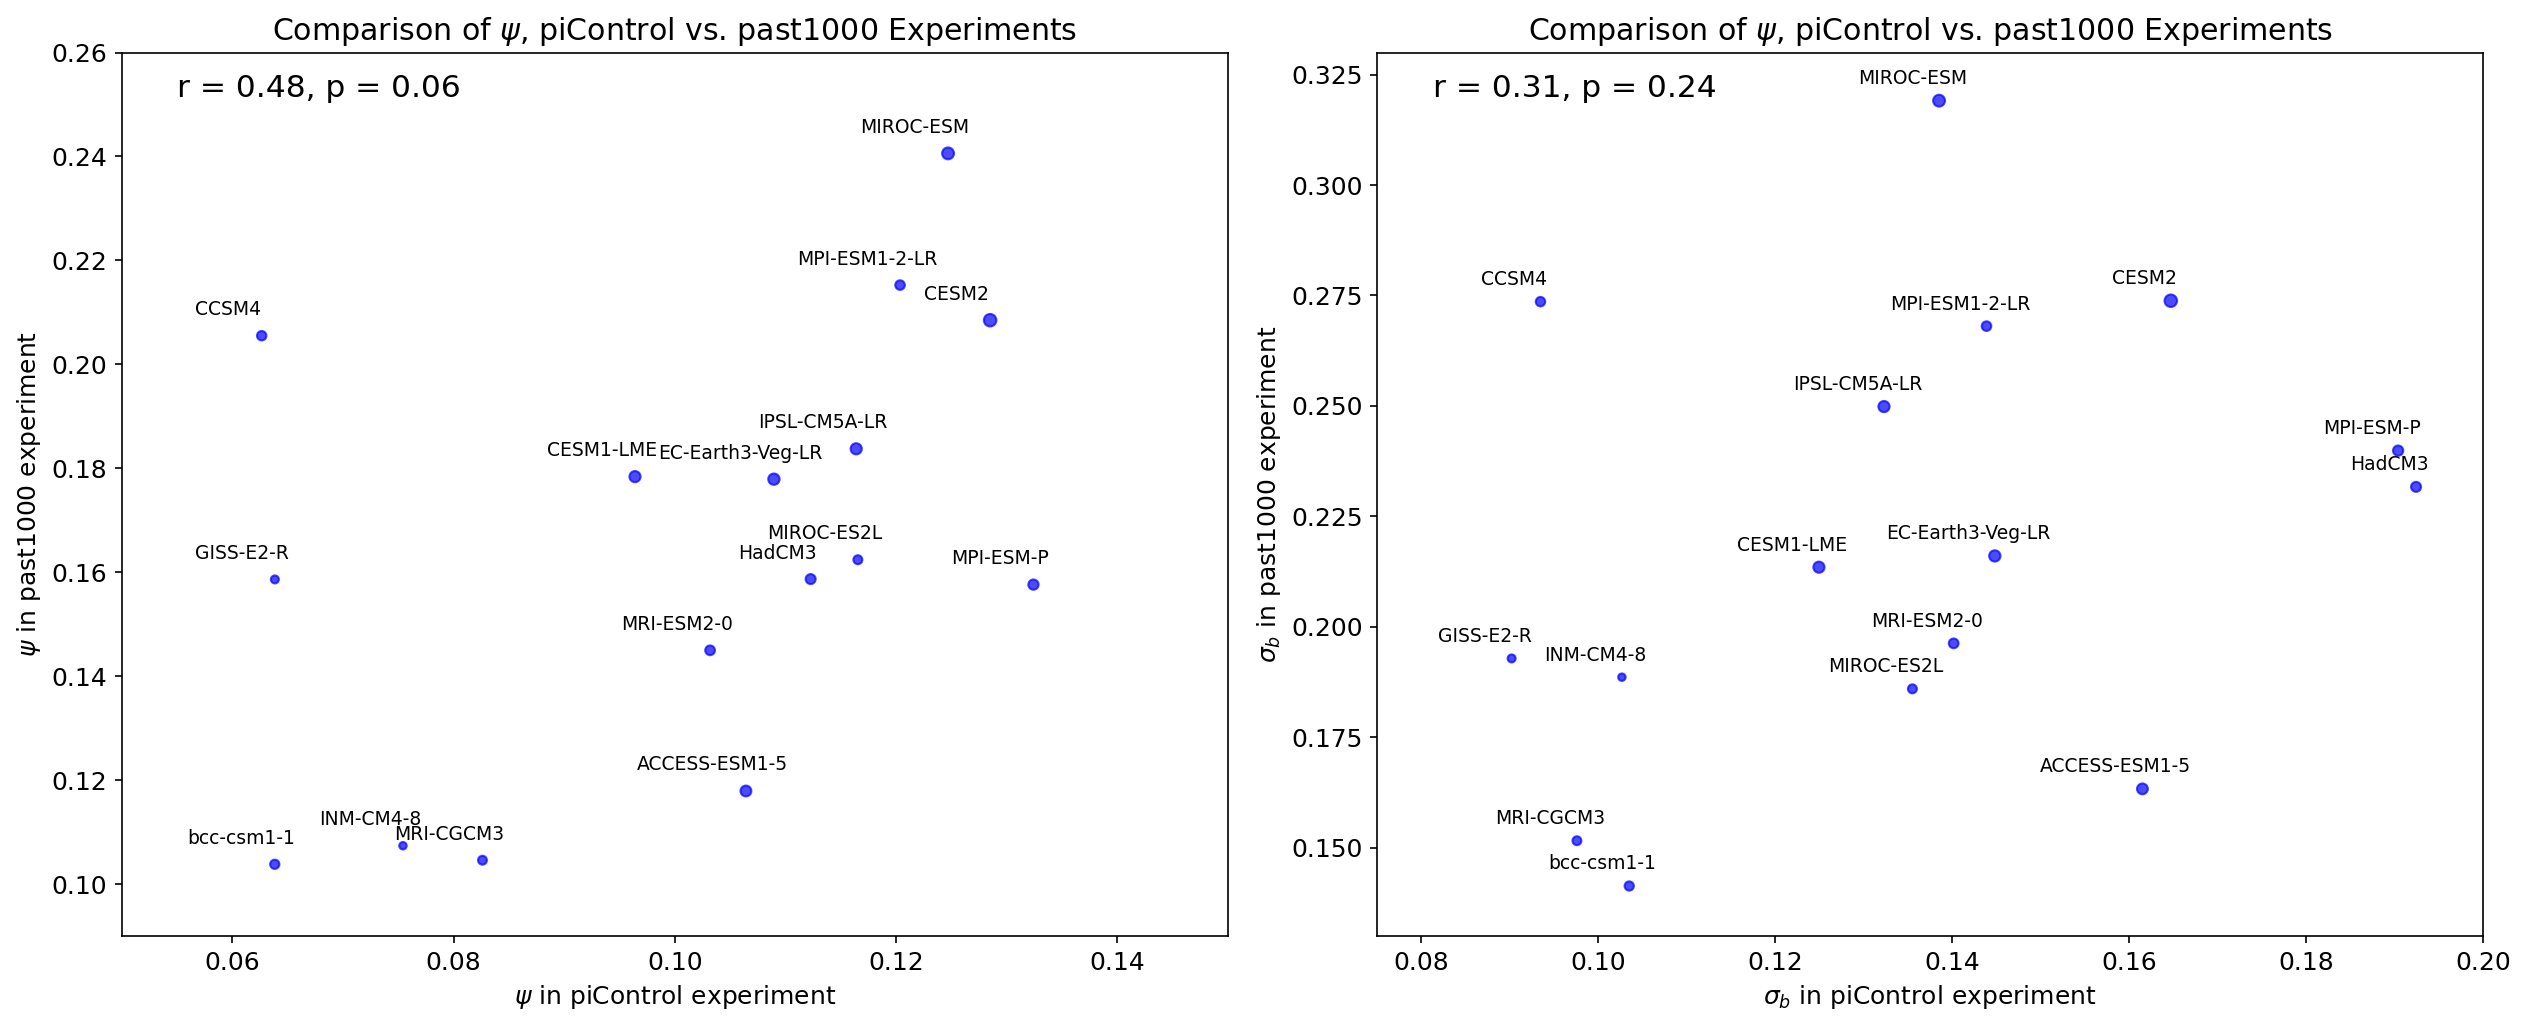

In [83]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def fix_up_dat(dat):
    try:
        dat=dat.rename({"longitude":"lon", "latitude":"lat"}) #problematic coord names
    except: pass
    
    dat = xr.decode_cf(dat, use_cftime = True)
    return dat

def weighted_mean(da):
    
    # make 2d array of weights in case that lat is 1d
    if len(da.lat.shape)==2:
        weights=np.cos(np.deg2rad(da.lat))
    elif len(da.lat.shape)==1:
        weights = xr.ones_like(da)* (np.cos(np.deg2rad((da.lat))).values)[:,np.newaxis]
        
    # turn weights into nan where da is nan
    weights = weights*da/da
    
    
    if 'lat' in da.dims:
        wm = (da*weights).sum(dim=['lat','lon']) / weights.sum(dim=['lat','lon'])

    elif 'i' in da.dims:
        wm = (da*weights).sum(dim=['i','j']) / weights.sum(dim=['i','j'])
    elif 'nlat' in da.dims:
        wm = (da*weights).sum(dim=['nlat','nlon']) / weights.sum(dim=['nlat','nlon'])
    elif 'x' in da.dims:
        wm = (da*weights).sum(dim=['x','y']) / weights.sum(dim=['x','y'])
    return wm

def compute_cox(x):
    x = x[~np.isnan(x)]
    psi_vals=[]
    for i in np.arange(0, len(x)-55):
        y = signal.detrend(x[i:i+55])
        auto_m1 = tsa.acf(y,nlags=1) # autocorrelation function from statsmodels
        auto_m1b = auto_m1[1]    # select 1 lag autocorrelation value
        sigma_m1= np.std(y)
        log_m1= np.log(auto_m1b)
        log_m1b = np.abs(log_m1)   # take absolute value
        sqrt_m1 = np.sqrt(log_m1b)
        psi = sigma_m1/sqrt_m1
        psi_vals.append(psi)
    return np.nanmean(psi_vals)

def compute_nijsse(x, length=10):
    # remove NaNs from the timeseries
    x = np.array(x)
    mask = ~np.isnan(x)
    x = x[mask]
    # fill it with slopes
    slopes = []
    i = 0
    while i < len(x)-length:
        slope, intercept, r, p, se = linregress(np.arange(0,length), x[i:i+length])
        slopes.append(length*slope)
        i+=length
    return np.nanstd(slopes)

def get_ecs(model_name):
    ecs_df = pd.read_csv('ecs.txt', header=7, delim_whitespace=True)
    return ecs_df[ecs_df['MODEL'] == model_name]['ECS'].values[0]

def construct_model_ts(zstore):
    dat = fix_up_dat(xr.open_zarr(gcs.get_mapper(zstore), consolidated=True))
    return weighted_mean(dat.tas.resample(time='1Y').mean('time')).values

cmip5 = {}
for pair in cmip5_schlund:
    model, ecs = pair
    try:
        ts=weighted_mean(xr.open_dataset('../../../pi_control_data/'+model+'.nc').resample(time='1Y').mean('time').tas)
        cmip5[model] = ts[:150]
    except:
        continue
        
cmip6 = {}
for pair in cmip6_schlund:
    model, ecs = pair
    try:
        ts=weighted_mean(xr.open_dataset('../../../pi_control_data/'+model+'.nc').resample(time='1Y').mean('time').tas)
        cmip6[model] = ts[:450]
    except:
        continue
        
paleomodels = [
    'bcc-csm1-1', 'CCSM4', 'CSIRO-Mk3L-1-2', 'FGOALS-gl',
    'GISS-E2-R', 'HadCM3', 'IPSL-CM5A-LR', 'MIROC-ES2L',
    'MPI-ESM-P', 'MRI-CGCM3', 'MRI-ESM2-0', 'CESM1-LME',
    'CESM2', 'MPI-ESM1-2-LR', 'EC-Earth3-Veg-LR', 'MIROC-ESM',
    'INM-CM4-8', 'ACCESS-ESM1-5'
]

df=pd.read_csv('data/ec_data.csv')

x=[]
y=[]
z=[]
model_names=[]

for model in paleomodels:
    if model=='EC-Earth3-Veg-LR':
        ts=weighted_mean(xr.open_dataset('../../../pi_control_data/EC-Earth3-Veg-LR.nc').resample(time='1Y').mean('time').tas)
        x.append(compute_cox(ts))
        y.append(float(df[df['model']==model]['rv_cox']))
        z.append(float(df[df['model']==model]['ecs']))
        model_names.append(model)
        continue
    if model=='CESM1-LME':
        ts=weighted_mean(xr.open_dataset('../../../pi_control_data/CESM1-CAM5.nc').resample(time='1Y').mean('time').tas)
        x.append(compute_cox(ts))
        y.append(float(df[df['model']==model]['rv_cox']))
        z.append(float(df[df['model']==model]['ecs']))
        model_names.append(model)
        continue
    if model=='HadCM3':
        ts=weighted_mean(xr.open_dataset('../../../pi_control_data/HadCM3.nc').resample(time='1Y').mean('time').tas)
        x.append(compute_cox(ts))
        y.append(float(df[df['model']==model]['rv_cox']))
        z.append(float(df[df['model']==model]['ecs']))
        model_names.append(model)
        continue
    try:
        ts=cmip6[model]
        x.append(compute_cox(ts))
        y.append(float(df[df['model']==model]['rv_cox']))
        z.append(float(df[df['model']==model]['ecs']))   
        model_names.append(model)
        continue
    except:
        try:
            ts=cmip5[model]
            x.append(compute_cox(ts))
            y.append(float(df[df['model']==model]['rv_cox']))
            z.append(float(df[df['model']==model]['ecs']))
            model_names.append(model)
            continue
        except:
            continue
            
x2=[]
y2=[]

for model in paleomodels:
    if model=='EC-Earth3-Veg-LR':
        ts=weighted_mean(xr.open_dataset('../../../pi_control_data/EC-Earth3-Veg-LR.nc').resample(time='1Y').mean('time').tas)
        x2.append(compute_nijsse(ts))
        y2.append(float(df[df['model']==model]['rv_nijsse']))
        continue
    if model=='CESM1-LME':
        ts=weighted_mean(xr.open_dataset('../../../pi_control_data/CESM1-CAM5.nc').resample(time='1Y').mean('time').tas)
        x2.append(compute_nijsse(ts))
        y2.append(float(df[df['model']==model]['rv_nijsse']))
        continue
    if model=='HadCM3':
        ts=weighted_mean(xr.open_dataset('../../../pi_control_data/HadCM3.nc').resample(time='1Y').mean('time').tas)
        x2.append(compute_nijsse(ts))
        y2.append(float(df[df['model']==model]['rv_nijsse']))
        continue
    try:
        ts=cmip6[model]
        x2.append(compute_nijsse(ts))
        y2.append(float(df[df['model']==model]['rv_nijsse']))
        continue
    except:
        try:
            ts=cmip5[model]
            x2.append(compute_nijsse(ts))
            y2.append(float(df[df['model']==model]['rv_nijsse']))
            continue
        except:
            continue
            

model = model_names            

# Create a figure with two subplots
# fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'wspace': 0.0})
fig, axs = plt.subplots(1, 2, figsize=(17, 7),)

# First subplot
scatter1 = axs[0].scatter(x, y, s=np.multiply(7, np.array(z)), c='blue', alpha=0.7)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
correlation_info = f'r = {r_value:.2f}, p = {p_value:.2f}'
axs[0].annotate(correlation_info, (0.05, 0.95), xycoords='axes fraction').set_size(15)
axs[0].set_title('Comparison of $\psi$, piControl vs. past1000 Experiments')
axs[0].set_xlabel('$\psi$ in piControl experiment')
axs[0].set_ylabel('$\psi$ in past1000 experiment')
axs[0].set_xlim(0.05,0.15)
axs[0].set_ylim(0.09,0.26)
texts1 = [axs[0].text(x[i]-0.003, y[i]+0.005, model[i], ha='center', va='center', fontsize=9) for i in range(len(model))]
axs[0].grid(False)

# Second subplot
scatter2 = axs[1].scatter(x2, y2, s=np.multiply(7, np.array(z)), c='blue', alpha=0.7)
slope, intercept, r_value, p_value, std_err = linregress(x2, y2)
correlation_info = f'r = {r_value:.2f}, p = {p_value:.2f}'
axs[1].annotate(correlation_info, (0.05, 0.95), xycoords='axes fraction').set_size(15)
axs[1].set_title('Comparison of $\psi$, piControl vs. past1000 Experiments')
axs[1].set_xlabel('$\sigma_{b}$ in piControl experiment')
axs[1].set_ylabel('$\sigma_{b}$ in past1000 experiment')
axs[1].set_xlim(0.075,0.2)
axs[1].set_ylim(0.13,0.33)
texts2 = [axs[1].text(x2[i]-0.003, y2[i]+0.005, model[i], ha='center', va='center', fontsize=9) for i in range(len(model))]
axs[1].grid(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('figures/figure_s6.png',dpi=1000)